# 00. Load packages

In [1]:
from sklearn.tree import DecisionTreeClassifier

from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

import os
from collections import Counter
import random

from tqdm import tqdm

import pandas as pds
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sbn


def cat_transform(df, cs):
    return_list = []
    numeric_columns = []
    
    for c in cs:
        # categorical column list 'cs' 중 하나인 "c"에 존재하는 고윳 값들 전부에 대응되는 숫자 생성
        unique_values = {i : n for n,i in enumerate(sorted(df[c].unique()))}
        
        # lambda를 활용하여 dataframe의 c column에 존재하는 각 값들을 숫자로 변환
        num_df = df[c].apply(lambda x: unique_values[x])
        
        # 만약 고윳값이 2개인 경우, 1열로 표현 가능 ( e.g. 0 - 1 or -1 - 1 )
        if len(unique_values) == 2:
            return_list.append(num_df.values.reshape(-1,1))
        
        # 만약 고윳값이 3개 이상인 경우, 고윳값 갯수만큼의 열을 활용한 one-hot encoding을 수행해야 함.
        # 단 너무 많은 고윳값의 경우 discrete numerical variables일 수 있기 때문에, one-hot encoding에서 제외함
        elif len(unique_values) < 10:
            return_list.append(np.eye(len(unique_values))[num_df])

        # 제외한 column들을 return하여 numerical preprocessing을 적용
        else:
            numeric_columns.append(c)
    return np.concatenate(return_list, 1), numeric_columns


def num_transform(df, cs):
    num_df = df[cs].copy().values
    
    #열별 평균으로 빼고 분산을 1로 변환하는 Standard scaling (a.k.a z-scaling)
    num_df = (df[cs].values - num_df.mean(0)) / (num_df.std(0) + 1e-10)
    return num_df


df = pds.read_csv('../files/Week 10. data-student.csv'
                  , delimiter=';'
                 )
print(df.shape)
Y = df['Target']
X = df.drop(columns = ['Target'], axis = 1)

Y = Y.apply(lambda x: 0 if x == 'Graduate' else (1 if x == 'Enrolled' else 2 ))


remove_columns = []
categorical_columns = []
numerical_columns = []

# 열별로 데이터 탐색 진행 = column을 순차대로 탐색하는 것과 같음
for c, t in X.iteritems():
    
    # 데이터가 만약 수치형이 아니라면 categorical에 대해 고민해 볼 필요 있음
    if t.dtype != np.float64:
        
        # 데이터에 존재하는 고윳값 갯수 계산
        n_unique = len(t.unique())
        
        # 고윳값이 단 하나라면 필요 없는 데이터일수 있음
        if n_unique == 1:
            remove_columns.append(c)
            
        # 아니라면 categorical preprocessing 적용
        else:
            categorical_columns.append(c)
            
    # 수치형이라면, 수치형에 대한 preprocessing 적용 
    else:
        numerical_columns.append(c)


cat_arr, add_numerical_columns = cat_transform(df, categorical_columns)
print(add_numerical_columns)
num_arr = num_transform(df, numerical_columns + add_numerical_columns)

df_arr = np.concatenate([num_arr, cat_arr], 1)

(4424, 37)
['Application mode', 'Course', 'Previous qualification', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (without evaluations)']


# 01. Decomposition - PCA

<img src = https://imgur.com/NreppEk.png width = 700>

In [2]:
from sklearn.decomposition import PCA

In [3]:
pca = PCA()
pca.fit(df_arr)
pca.explained_variance_ratio_.cumsum()

array([0.22753288, 0.32719142, 0.40154425, 0.46646501, 0.5270942 ,
       0.58308496, 0.63479048, 0.68001792, 0.7168531 , 0.75234137,
       0.78135428, 0.80828404, 0.83307788, 0.85408239, 0.8709234 ,
       0.88653752, 0.90120926, 0.9145079 , 0.92480158, 0.93356704,
       0.9408206 , 0.94767195, 0.95395557, 0.95982851, 0.96530108,
       0.96982934, 0.97355176, 0.97693504, 0.9802528 , 0.98341095,
       0.98651727, 0.98894734, 0.99116884, 0.9932406 , 0.99470205,
       0.99598059, 0.99714   , 0.99814241, 0.99889612, 0.99930304,
       0.99961954, 0.99988316, 0.99994517, 0.99998123, 0.99999196,
       1.        , 1.        , 1.        ])

In [4]:
pca_outputs = pca.transform(df_arr)

In [5]:
PCA_df = pds.DataFrame(
    np.concatenate([pca_outputs[:,:2], df['Target'].values.reshape(-1,1)], 1),
    columns = ['x1','x2','label']
)

<AxesSubplot:xlabel='x1', ylabel='x2'>

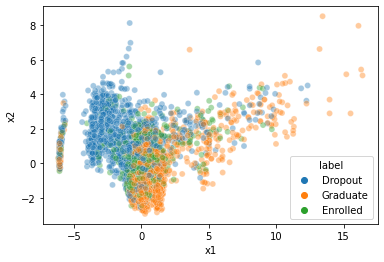

In [6]:
sbn.scatterplot(data = PCA_df, x = 'x1', y = 'x2', alpha = .4, hue = 'label')


# 02. Decomposition - AutoEncoder

<img src = https://imgur.com/9wC8oQe.png width = 700>

In [7]:
import torch
import pytorch_lightning as pl
import torchmetrics



class custom_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y = None, training = True):
        super().__init__()
        
        self._training = training
        self._X = x.astype(np.float32)
        if self._training:
            self._Y = y

            
    def __len__(self):
        return len(self._X)
    
    
    def __getitem__(self, idx):
        if self._training:
            return self._X[idx], self._Y[idx]
        else:
            return self._X[idx]

        
        
class pl_datamodule(pl.LightningDataModule):
    def __init__(self, train, batch_size = 64):
        super().__init__()
        self._train = train
        self._batch_size = batch_size
        
                     
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = custom_dataset(*self._train)

        elif stage == "test" or stage is None:
            pass
                     
                     
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size = self._batch_size, shuffle = True)
                     
    
    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size = self._batch_size)
                     
    
class pl_model(pl.LightningModule):
    def __init__(self, dims, lr = 1e-3, device = None):
        super().__init__()
            
        self.enc_input_dims = dims
        self.enc_output_dims = dims[1:]
        
        self.dec_input_dims = dims[::-1]
        self.dec_output_dims = dims[::-1][1:]
        
        self.dims_flag = [False] * (len(self.enc_output_dims) - 1) + [True]
        self._lr = lr
        
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        self.loss_fn = torch.nn.functional.mse_loss
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self._lr)

    
    def build_block(self, i, o, output_flag = False):
        if output_flag:
            return torch.nn.Linear(i,o)
        else:
            return torch.nn.Sequential(
                torch.nn.Linear(i, o),
                torch.nn.ReLU(),
            )
    
    
    def build_encoder(self):
        nets = []
        for i,o,f in zip(self.enc_input_dims, self.enc_output_dims, self.dims_flag):
            print(i,o,f)
            nets.append(self.build_block(i,o,f))
        return torch.nn.ModuleList(nets)

    
    def build_decoder(self):
        nets = []
        for i,o,f in zip(self.dec_input_dims, self.dec_output_dims, self.dims_flag):
            print(i,o,f)
            nets.append(self.build_block(i,o,f))
        return torch.nn.ModuleList(nets)

    
    def encode(self, x):
        for l in self.encoder:
            x = l(x)
        return x
        
        
    def decode(self, x):
        for l in self.decoder:
            x = l(x)
        return x
    
        
    def forward(self, x):
        enc_x = self.encode(x)
        dec_x = self.decode(enc_x)
        return dec_x
        
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, x)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        return self.encode(x)
        
    

In [8]:
dims = [df_arr.shape[1], 32, 16, 8, 2]
dims

[48, 32, 16, 8, 2]

In [9]:
DM = pl_datamodule((df_arr, Y.values), 16)
DM.setup('fit')

model = pl_model(dims)

48 32 False
32 16 False
16 8 False
8 2 True
2 8 False
8 16 False
16 32 False
32 48 True


In [10]:
trainer = pl.Trainer(
    # accelerator='gpu', 
    # devices=[0],
    max_epochs=50,
)

model.train()
trainer.fit(model, DM)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | ModuleList | 2.2 K 
1 | decoder | ModuleList | 2.3 K 
---------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
c:\Users\keb20\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 277/277 [00:09<00:00, 30.52it/s, loss=0.233, v_num=1, train_loss=0.236]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 277/277 [00:09<00:00, 30.38it/s, loss=0.233, v_num=1, train_loss=0.236]


In [11]:
AE_outputs = trainer.predict(model, DM)

c:\Users\keb20\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 277/277 [00:02<00:00, 94.50it/s] 


In [12]:
AE_df = pds.DataFrame(
    np.concatenate([torch.cat(AE_outputs).numpy(), df['Target'].values.reshape(-1,1)], 1),
    columns = ['x1','x2','label']
)

<AxesSubplot:xlabel='x1', ylabel='x2'>

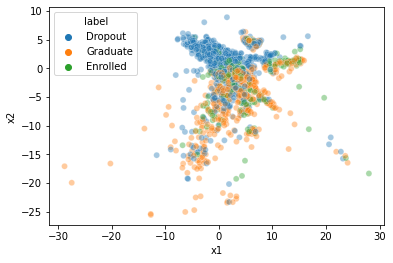

In [13]:
sbn.scatterplot(data = AE_df, x = 'x1', y = 'x2', alpha = .4, hue = 'label')


# 03. Representation - Contrasitive learning

<img src = https://imgur.com/lW4EKTN.png width = 700>